<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/cv/2347111_CV_Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Contouring

> Bivas Kumar

> 2347111

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Curing the video and an image

> The video was cropped in length to $10$ seconds.
> The frame at $00:00:00$ was then extracted.
> All of these were done via the **ffmpeg** command line for the sake of simplicity.

In [4]:
VIDEO_PATH = "/content/drive/MyDrive/Trimester/5/cv/car_video.mp4"
IMAGE_PATH = "/content/drive/MyDrive/Trimester/5/cv/car_image.jpg"

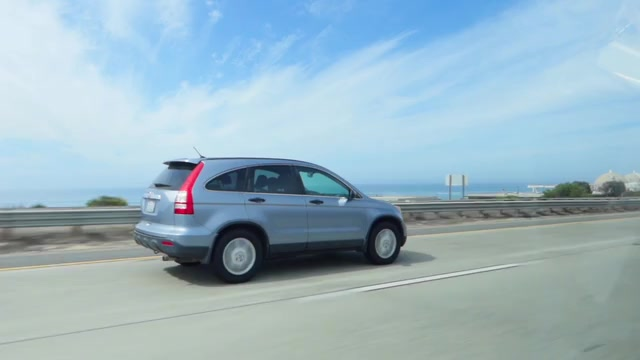

In [7]:
import cv2

from google.colab.patches import cv2_imshow


car_image = cv2.imread(IMAGE_PATH)
cv2_imshow(car_image)

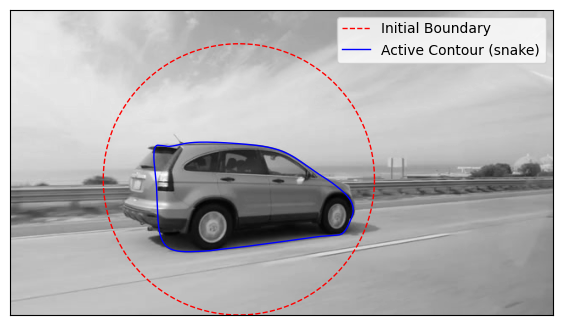

In [97]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour


img = rgb2gray(io.imread(IMAGE_PATH))

# Defining an initial circular contour around the
# center of the car in the image.
center_row, center_col = 200, 270

# radius to roughly fit the car
radius = 160

# Refer:
# https://scikit-image.org/docs/stable/auto_examples/edges/plot_active_contours.html#active-contour-model
# The docs present this solution for a Active Contour around an astronaut's face.
# We could do a similar approach here by drawing a boundary around the card
# in the first frame and then iterating over the rest of the frames
# in the video and updating at each step, thus contouring the car throughout the video.
s = np.linspace(0, 2 * np.pi, 420)
r = center_row + radius * np.sin(s)
c = center_col + radius * np.cos(s)
init = np.array([r, c]).T

# perform Active Contour (snake) algorithm
snake = active_contour(
    gaussian(img, sigma=3, preserve_range=False),
    init,
    alpha=0.01,  # elasticity, shape
    beta=1,  # rigidity, fine detail
    gamma=0.005,  # convergence
)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=1, label='Initial Boundary')
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1, label='Active Contour (snake)')
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
ax.legend()

plt.show()

In [98]:
import os
import cv2
import imageio
import numpy as np

from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour


cap = cv2.VideoCapture(VIDEO_PATH)

# parameters for the snake
alpha = 0.01
beta = 5
gamma = 0.005

# Defining initial circular contour around the car in the first frame.
# This is taken from Active Contouring the first frame (see cell above).
center_row, center_col = center_row, center_col
radius = radius

s = np.linspace(0, 2 * np.pi, 420)
r = center_row + radius * np.sin(s)
c = center_col + radius * np.cos(s)
init_snake = np.array([r, c]).T

# store frames with the snake contour
output_frames = []

# process each frame
ret, frame = cap.read()
frame_index = 0

while ret:
  # convert to grayscale
  gray_frame = rgb2gray(frame)

  # apply Gaussian smoothing before drawing the initial boundary
  smoothed_frame = gaussian(gray_frame, sigma=3, preserve_range=False)

  # run the snake algorithm on the current frame
  snake = active_contour(
      smoothed_frame,
      init_snake,
      alpha=alpha,
      beta=beta,
      gamma=gamma,
  )

  # draw the contour on the frame
  frame_with_snake = frame.copy()
  for point in snake:
      y, x = int(point[0]), int(point[1])
      cv2.circle(frame_with_snake, (x, y), 1, (255, 0, 0), -1)  # blue snake contour (B, G, R)

  # append the processed frame to the output list
  output_frames.append(cv2.cvtColor(frame_with_snake, cv2.COLOR_BGR2RGB))  # convert to RGB for imageio

  # update initial contour for the next frame
  init_snake = snake

  # read next frame
  ret, frame = cap.read()
  frame_index += 1

  # the video was inspected via ffmpeg cli to have 229 frames
  if frame_index >= 229:
      break

cap.release()

# save the output frames as a video
output_video_path = '/content/drive/MyDrive/Trimester/5/cv/snake_car_video.mp4'
imageio.mimsave(output_video_path, output_frames, fps=23, macro_block_size=8)